# Project: Virtual Makeup
Interesting applications of facial features and landmarks. In this project, you will build features for a Virtual Makeup application! Given below are a few features that are required to be built in the application. 

- Apply Lipstick
- Apply Eyebrows deepen
- Apply Blush




In [186]:
import cv2,sys,dlib,time,math
import numpy as np
import faceBlendCommon as fbc
import mls as mls

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

%matplotlib inline

# Load landmark detector
Loading the model for landmark detector.

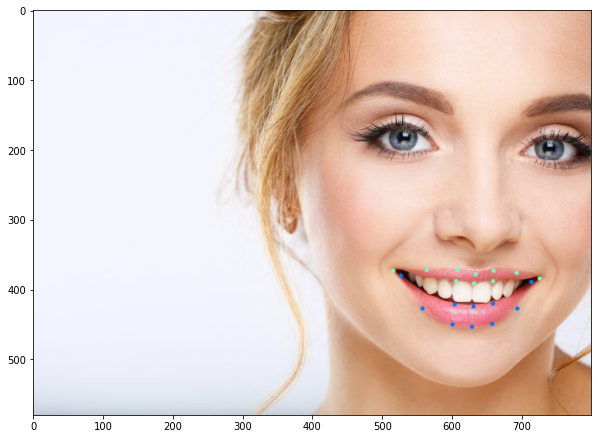

In [243]:
# Landmark model location
PREDICTOR_PATH =  "shape_predictor_68_face_landmarks.dat"
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

image = cv2.imread("smile1.jpg" )   
imDlib = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)

selectedIndex_upper_lip = [ 48, 49, 50, 51, 52, 53, 54, 61, 62, 63]
selectedIndex_bottom_lip = [ 55, 56, 57, 58, 59, 60, 64, 65, 66, 67]

for i in selectedIndex_upper_lip:
    cv2.circle(imDlib, points[i], 3, (120, 255, 180), -1)
for i in selectedIndex_bottom_lip:
    cv2.circle(imDlib, points[i], 3, (0, 120, 255), -1)
plt.figure(figsize = (10, 10))
plt.imshow(imDlib)
plt.show()


# Feature 1: Lipstick
Write code for the first feature you want to implement from the above list. Display the output image after writing the code.

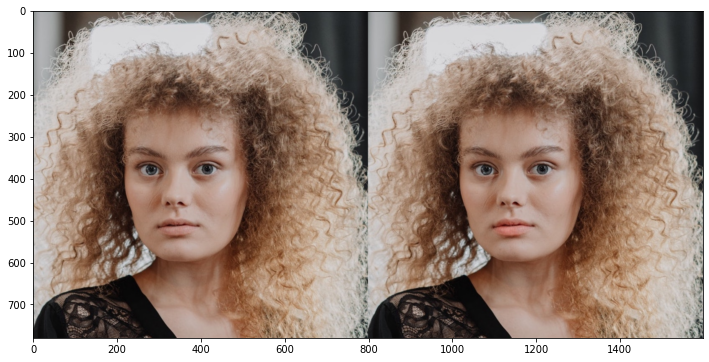

In [258]:
im = cv2.imread("no-makeup.jpg" ) 

imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img1Warped = np.copy(imDlib)

landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)

selectedIndex_upper_lip  = [ 48, 49, 50, 51, 52, 53, 54, 61, 62, 63]
selectedIndex_botto_lip  = [ 55, 56, 57, 58, 59, 60, 64, 65, 66, 67]


hull1, hull2 = [], []

for i in selectedIndex_upper_lip:
    hull1.append(landmarks[i])
    
for j in selectedIndex_botto_lip:
    hull2.append(landmarks[j])


mask1 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.fillConvexPoly(mask1, np.array([hull1], dtype=np.int32), (255, 0, 0))

mask2 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.fillConvexPoly(mask2, np.array([hull2], dtype=np.int32), (255, 0, 0))

mask = cv2.addWeighted(mask1, 1, mask2, 1, 0.0)

# Blurring face mask to alpha blend to hide seams
maskHeight, maskWidth = mask.shape[0:2]
maskSmall = cv2.resize(mask, (256, int(maskHeight*256.0/maskWidth)))
maskSmall = cv2.erode(maskSmall, (-1, -1), 11)
maskSmall = cv2.GaussianBlur(maskSmall, (11, 11), 0, 0)
mask = cv2.resize(maskSmall, (maskWidth, maskHeight))

feature_image = cv2.addWeighted(mask, 0.1, imDlib, 1, 0.0)
displayImage = np.hstack((imDlib, feature_image))

feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("image.jpg", feature_image)

plt.figure(figsize = (12, 12))
plt.imshow(displayImage)
plt.show()


# Feature 2: Eyebrows deepen

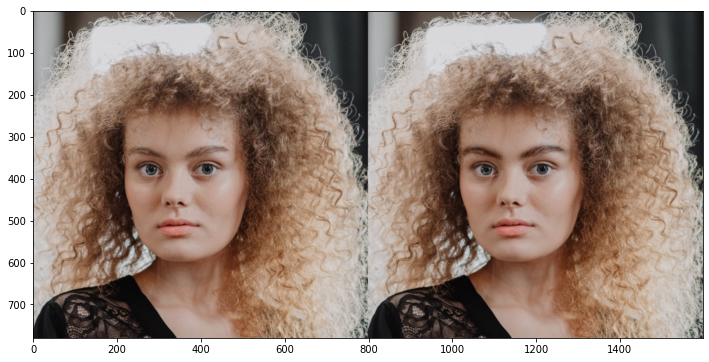

In [262]:
im = cv2.imread("image.jpg" ) 

imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img1Warped = np.copy(imDlib)

landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)

selectedIndex_upper_lip  = [ 17, 18, 19, 20, 21]
selectedIndex_botto_lip  = [ 22, 23, 24, 25, 26]


hull1, hull2 = [], []

for i in selectedIndex_upper_lip:
    hull1.append(landmarks[i])
    
for i in selectedIndex_botto_lip:
    hull2.append(landmarks[i])


mask1 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.polylines(mask1, np.array([hull1], dtype=np.int32), False, (250, 250, 250), 5)

mask2 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.polylines(mask2, np.array([hull2], dtype=np.int32), False, (250, 250, 250), 5)

mask = cv2.addWeighted(mask1, 1, mask2, 1, 0.0)

# Blurring face mask to alpha blend to hide seams
maskHeight, maskWidth = mask.shape[0:2]
maskSmall = cv2.resize(mask, (256, int(maskHeight*256.0/maskWidth)))
maskSmall = cv2.erode(maskSmall, (-1, -1), 21)
maskSmall = cv2.GaussianBlur(maskSmall, (11, 11), 0, 0)
mask = cv2.resize(maskSmall, (maskWidth, maskHeight))

feature_image = cv2.addWeighted(mask, -0.6, imDlib, 1, 0.0)
displayImage = np.hstack((imDlib, feature_image))

feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("image.jpg", feature_image)

plt.figure(figsize = (12, 12))
plt.imshow(displayImage)
plt.show()

# Feature 3: Blush

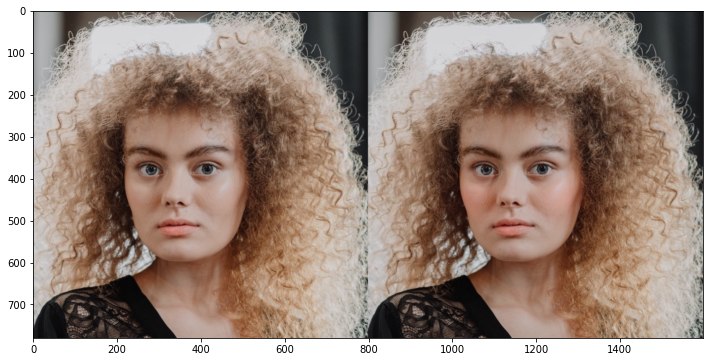

In [263]:
im = cv2.imread("image.jpg" ) 

imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img1Warped = np.copy(imDlib)

landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)

selectedIndex_upper_lip  = [  1 , 2 , 3 , 4 , 31, 40, 41]
selectedIndex_botto_lip  = [  13, 14, 15, 16, 35, 46, 47]


hull1, hull2 = [], []

for i in selectedIndex_upper_lip:
    hull1.append(landmarks[i])
    
for i in selectedIndex_botto_lip:
    hull2.append(landmarks[i])


mask1 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.fillConvexPoly(mask1, np.array([hull1], dtype=np.int32),  (250, 0, 0))

mask2 = np.zeros(imDlib.shape, dtype=imDlib.dtype)
cv2.fillConvexPoly(mask2, np.array([hull2], dtype=np.int32),  (250, 0, 0))

mask = cv2.addWeighted(mask1, 1, mask2, 1, 0.0)

# Blurring face mask to alpha blend to hide seams
maskHeight, maskWidth = mask.shape[0:2]
maskSmall = cv2.resize(mask, (256, int(maskHeight*256.0/maskWidth)))
maskSmall = cv2.erode(maskSmall, (-1, -1), 21)
maskSmall = cv2.GaussianBlur(maskSmall, (71, 71), 0, 0)
mask = cv2.resize(maskSmall, (maskWidth, maskHeight))

feature_image = cv2.addWeighted(mask, 0.1, imDlib, 0.98, 0.0)
displayImage = np.hstack((imDlib, feature_image))

feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("image.jpg", feature_image)

plt.figure(figsize = (12, 12))
plt.imshow(displayImage)
plt.show()